# Assign Reads

This script makes sure the clusters do not flip as the sliding window moves to the right.

# Load modules

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set Variables

In [17]:
# Input variables
run_number="run1"
chrom="chr11"
dis="sca"
# Setup
chrom_dis=f"{chrom}_{dis}"
datadir=f"/mnt/aretian/genomics/nanopore/{run_number}"

os.environ["run_number"]=run_number
os.environ["chrom"]=chrom
os.environ["chrom_dis"]=chrom_dis
os.environ["datadir"]=datadir

# Load data

In [18]:
# Load read_clusters

# results_file = pd.read_csv(f"../data/processed/{chromosomeID}_read_clusters_5000_1000_200iter.txt")
# results_file = pd.read_csv(f"../data/processed/{chromosomeID}_read_clusters_10000_3000_200iter.txt")
# results_file = pd.read_csv(f"{datadir}/{run_number}_{chrom}_read_clusters.txt")
results_file = pd.read_csv(f"{datadir}/{run_number}_{chrom}_read_clusters.txt")

results_file.columns = ['ID', 'kmeans_cls2', 'window_num']

# Load Nanopore Reads
nanopore_reads = pd.read_csv(f"{datadir}/{run_number}_{chrom_dis}_clean.csv") # load nanopore reads with padded sequences and other attribute data

# Add column(s)
nanopore_reads['individual'] = np.nan
results_file['individual'] = np.nan

# Helper functions

In [19]:
def propagate_assignment_1(read):
    print('_', end="")
    
    ID = read['ID']
    individual = read['individual']
    
    # Write results
    nanopore_reads.loc[nanopore_reads.ID == ID, 'individual'] = individual # propagate the person assignment to the main reads dataframe
    results_file.loc[results_file['ID'] == ID, 'individual'] = individual # propagate the person assignment to the main reads dataframe
    ID_person_match[ID] = individual # add result to dictionary of results

def propagate_assignment_2(read):
#     print('Inside propagate 2')
    ID = read['ID']
    individual = read['individual']
#     print('Looking for readID in history')

    if ID in ID_person_match.keys():
        # ID has already been assigned 
        # NOTE: same as "if np.isnan(read_result['individual']) == False"
        print("-", end="")
        return None
    
#     print('did not find readID in history')
    # Get cluster assignment of read: 0 or 1
#     cluster_num = window_reads.loc[window_reads['ID'] == ID, 'kmeans_cls2'].values[0]
    cluster_num = read['kmeans_cls2']

    # see the individual assigned to IDs in this cluster in this particular window
    cluster_family = window_reads.loc[window_reads['kmeans_cls2'] == cluster_num]
    cluster_family_notna = cluster_family.loc[cluster_family['individual'].notnull()]
    assigned_individual = cluster_family_notna['individual'].unique()
#     print(f'Assigned individual: {assigned_individual}')


    if len(assigned_individual) > 1:
        # this cluster has mixed assignment which is bad
        # we expect that if IDs are already assigned they were in the same cluster in the previous window(s)
        # which means that this issue should theoretically never happen (NOTE: think about/check this logic)
#         print('ERROR: Found a window with person0 and person1 in the same cluster.')
#         print("E", end="")
#         return None
#         print('Multiple assigned individuals in cluster.')

#         # Make a call for this reads with mixed assignment
        mean_individual_to_assign = cluster_family_notna['individual'].mean()
        if mean_individual_to_assign == 0.5:
            if loop_direction=='left':
                individual_to_assign = cluster_family_notna['individual'].iloc[-1]
            else:
                individual_to_assign = cluster_family_notna['individual'].iloc[0]
            print("T", end="")
        else:
            individual_to_assign = round(mean_individual_to_assign) 
            print("E", end="")
            
#         # Write results
        nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'] = individual_to_assign # propagate the person assignment to the main reads dataframe
        results_file.loc[results_file['ID'] == ID, 'individual'] = individual_to_assign # propagate the person assignment to the main reads dataframe
        ID_person_match[ID] = individual_to_assign # add result to dictionary of results
        

    elif len(assigned_individual) == 0:
#         print('All reads in cluster are unassigned.')

        # All reads in the cluster_family are unassigned (NaN)
        # Look at what is the assigned individual of the opposite cluster
        other_cluster_family = window_reads.loc[window_reads['kmeans_cls2'] == (1-cluster_num)]
        other_cluster_family_notna = other_cluster_family.loc[other_cluster_family['individual'].notnull()]
        other_assigned_individual = other_cluster_family_notna['individual'].unique()
#         print(f'New read. Other assigned individual: {other_assigned_individual[0]}')
        print("o", end="")
        
        # Assign the opposite individual
        individual_to_assign = 1-other_assigned_individual[0]
        
        # Bulk write results
        for ID in cluster_family['ID'].unique(): # For every read in the same cluster
            if nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'].isna().values[0]:
                nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'] = individual_to_assign # propagate the person assignment to the main reads dataframe
                results_file.loc[results_file['ID'] == ID, 'individual'] = individual_to_assign # propagate the person assignment to the main reads dataframe
                ID_person_match[ID] = individual_to_assign # add result to dictionary of results
        
    elif len(assigned_individual) == 1:
#         print('Reads in cluster have already been assigned.')

        print("s", end="")
        
        # Reads in the same cluster have already been assigned
        individual_to_assign = assigned_individual[0] # check this syntax

        # Bulk write results
        for ID in cluster_family['ID'].unique():
            if nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'].isna().values[0]:
                nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'] = individual_to_assign # propagate the person assignment to the main reads dataframe
                results_file.loc[results_file['ID'] == ID, 'individual'] = individual_to_assign # propagate the person assignment to the main reads dataframe
                ID_person_match[ID] = individual_to_assign # add result to dictionary of results


In [20]:
# for ID in cluster_family.ID.unique():
#     print(type(ID))
#     print(ID)
#     print(nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'].notnull().values[0])
#     if np.isnan(nanopore_reads.loc[nanopore_reads['ID'] == ID, 'individual'].values[0]):
#         print('It is null')

# cluster_family

# nanopore_reads.loc[nanopore_reads.ID == 33]

# if np.isnan(nanopore_reads.loc[nanopore_reads['ID'] == 33, 'individual'].values[0]):
#     print('It is null')

# cluster_family = window_reads.loc[window_reads['kmeans_cls2'] == 0]
# cluster_family_notna = cluster_family.loc[cluster_family['individual'].notnull()]
# assigned_individual = cluster_family_notna['individual'].unique()

# assigned_individual[0]

# Main Loop: check assignment

In [21]:
# Setup
ID_person_match = {} #Dictionary to keep track of kmeans cluster and individual assignment
first_iter = True

# Feedback to user
n_windows = results_file['window_num'].nunique()
print(f"Total windows: {n_windows}")

print("")
print("_: First read.")
print("-: Individual already assigned.")
print("s: New read. Sibling already assigned.")
print("o: New read. Read in other cluster already assigned.")
print("E: New read. Siblings in both clusters (tie). Assign average rounded to 0 or 1.")
print("T: New read. Siblings in both clusters (tie). Assign individual from oldest read.")
print("")

print(f"Current window:", end="")

# Identify idmax of window
window_idxmax = results_file.groupby('window_num').count().idxmax().values[0]
# Loop to the left
loop_direction = 'left'

for window in range(window_idxmax+1,-1,-1):
# for window in results_file['window_num'].unique(): # iterate through instances of the sliding window 
    
    print(f" {window}", end="")
    
    window_reads = results_file.loc[results_file['window_num']==window].copy() # get data only from this window
    
#     # If window does not exist, skip
#     if len(window_reads)==0:
#         print("1", end="")
#         continue
    
    # We now have IDs, cluster decisions (0,1) for every read that was included in this window.
    
    # Step 1: We make a decision in the first window
    if first_iter == True:
        
        # Make decision in first window
        window_reads.loc[window_reads['kmeans_cls2'] == 0, 'individual'] = 0
        window_reads.loc[window_reads['kmeans_cls2'] == 1, 'individual'] = 1
        
        window_reads.apply(lambda x: propagate_assignment_1(x), axis=1) # add results to main reads file
        
        first_iter = False
        continue
    
#     print('Stepping inside propagate 2...')
    # Step 2: We perform ID bookeeping and cluster association to manage all following windows
    # Book-keeping:
    # Step 1: make sure IDs match for ones that are already claimed
    # Step 2: if an ID has not been assigned determine its cluster (0,1) assign the associated individual based on already assigned reads in the cluster
    window_reads.apply(lambda x: propagate_assignment_2(x), axis=1) # add results to main reads file
    
# Loop right
loop_direction = 'right'
max(results_file['window_num'])

for window in range(window_idxmax+2,max(results_file['window_num'])+1,1):
    
    print(f" {window}", end="")
    
    window_reads = results_file.loc[results_file['window_num']==window].copy() # get data only from this window
    
    # We now have IDs, cluster decisions (0,1) for every read that was included in this window.
    
    # Step 1: We make a decision in the first window
#     if first_iter == True:
        
#         # Make decision in first window
#         window_reads.loc[window_reads['kmeans_cls2'] == 0, 'individual'] = 0
#         window_reads.loc[window_reads['kmeans_cls2'] == 1, 'individual'] = 1
        
#         window_reads.apply(lambda x: propagate_assignment_1(x), axis=1) # add results to main reads file
        
#         first_iter = False
#         continue
        
    # Step 2: We perform ID bookeeping and cluster association to manage all following windows
    # Book-keeping:
    # Step 1: make sure IDs match for ones that are already claimed
    # Step 2: if an ID has not been assigned determine its cluster (0,1) assign the associated individual based on already assigned reads in the cluster
    window_reads.apply(lambda x: propagate_assignment_2(x), axis=1) # add results to main reads file

print("")
print("Finished running.")

Total windows: 3965

_: First read.
-: Individual already assigned.
s: New read. Sibling already assigned.
o: New read. Read in other cluster already assigned.
E: New read. Siblings in both clusters (tie). Assign average rounded to 0 or 1.
T: New read. Siblings in both clusters (tie). Assign individual from oldest read.

Current window: 2072______________ 2071--s------------- 2070--------------- 2069-E------------ 2068------------ 2067------------ 2066----------- 2065--------- 2064--------- 2063------- 2062------- 2061------- 2060------ 2059---s--- 2058------- 2057------- 2056------- 2055------- 2054E------- 2053----T---- 2052-------- 2051------- 2050------ 2049------ 2048------ 2047---E--- 2046------- 2045--s-- 2044---s-- 2043-----s- 2042------ 2041------ 2040------ 2039------ 2038---s---- 2037------- 2036------- 2035------ 2034--s---- 2033------- 2032------ 2031------ 2030-----s- 2029------- 2028------- 2027------- 2026------- 2025------ 2024------ 2023------ 2022s---- 2021---- 2020-

# Check Results

We prefer within cluster errors to inter window errors

Window with most reads: 2071


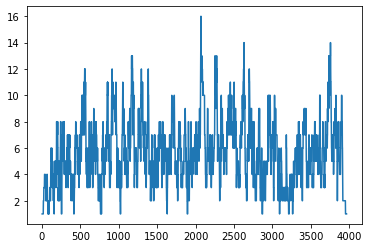

In [22]:
# Window with most reads
print(f"Window with most reads: {results_file.groupby('window_num').count()['ID'].idxmax()}")
plt.plot(results_file.groupby('window_num').count()['ID'])

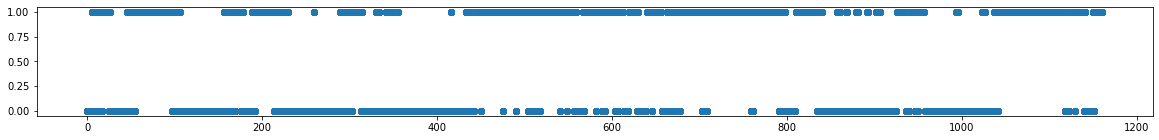

In [23]:
# View read assignment
fig, ax = plt.subplots(figsize=(20,2))
plt.scatter(results_file['ID'], results_file['individual'])

In [24]:
# Are there NaNs?
results_file.loc[results_file['individual'].isna()]

,ID,kmeans_cls2,window_num,individual


# Create Bam Files

### Get list of IDs for both persons

In [31]:
individual0_size = nanopore_reads[nanopore_reads['individual']==0].__len__()
individual1_size = nanopore_reads[nanopore_reads['individual']==1].__len__()
print(f"Assigned {individual0_size} reads to individual 0.")
print(f"Assigned {individual1_size} reads to individual 1.")

# Create ID column
# nanopore_reads['uniqueid']=nanopore_reads['QNAME']+'\t'+nanopore_reads['FLAG'].apply(str)+'\t'+nanopore_reads['RNAME'].apply(str)+'\t'+nanopore_reads['POS'].apply(str)
nanopore_reads['uniqueid']=nanopore_reads['QNAME'] # Fix later to replace with unique ids as above

# Write two text files
for person in [0,1]:
    # Get IDs of Person
    personuniqueids = nanopore_reads.loc[nanopore_reads['individual']==person, 'uniqueid']
    # Save to text file
    np.savetxt(f"{datadir}/{run_number}_{chrom}_person{person}_uniqueids.txt", personuniqueids.values , fmt='%s')

### Extract selected IDs from bam file

In [16]:
%%bash
cd $datadir

# Get reads
/home/fer/miniconda3/envs/genomics/bin/samtools view "${run_number}_${chrom_dis}.bam" | grep -f "${run_number}_${chrom}_person0_uniqueids.txt" > "${run_number}_${chrom}_person0_reads.sam"
/home/fer/miniconda3/envs/genomics/bin/samtools view "${run_number}_${chrom_dis}.bam" | grep -f "${run_number}_${chrom}_person1_uniqueids.txt" > "${run_number}_${chrom}_person1_reads.sam"
# Get header
/home/fer/miniconda3/envs/genomics/bin/samtools view -H "${run_number}_${chrom_dis}.bam" > "${run_number}_${chrom}_person_header.txt"
# Concatenate
cat "${run_number}_${chrom}_person_header.txt" "${run_number}_${chrom}_person0_reads.sam" > "${run_number}_${chrom}_person0.sam"
cat "${run_number}_${chrom}_person_header.txt" "${run_number}_${chrom}_person1_reads.sam" > "${run_number}_${chrom}_person1.sam"
# Convert to bam file
/home/fer/miniconda3/envs/genomics/bin/samtools view -b "${run_number}_${chrom}_person0.sam" > "strspy/input/${run_number}_${chrom}_person0.bam"
/home/fer/miniconda3/envs/genomics/bin/samtools view -b "${run_number}_${chrom}_person1.sam" > "strspy/input/${run_number}_${chrom}_person1.bam"
# Index bam file
/home/fer/miniconda3/envs/genomics/bin/samtools index "strspy/input/${run_number}_${chrom}_person0.bam"
/home/fer/miniconda3/envs/genomics/bin/samtools index "strspy/input/${run_number}_${chrom}_person1.bam"

# Save results

In [14]:
# ID_individual_mapping = pd.DataFrame(ID_person_match.items()) 
# ID_individual_mapping.to_csv('../data/processed/ID_individual_matches.csv')

# nanopore_reads.to_csv(f'../data/processed/{reads_filename}_checked.csv)

# results_file.to_csv('../data/processed/{chromosomeID}_read_clusters_checked.txt')